In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

plt.rcParams["font.size"] = 12
from datetime import datetime

# Lecture 19: Time series

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

### Announcements


- HW8 has been released. (Due next week Monday.)
- Thank you for filling out the midterm survey!
    - We'll try to be more responsive on Piazza. 
    - Our lectures are recorded. You can find the Panopto links for each section on Canvas. 

### iClicker

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements you agree with.**

- (A) Worksheets are effective. 
- (B) Cat photos are great.
- (C) Demos need to be more readable.
- (D) Lectures should be different than class notes.
- (E) Lectures could be more exciting.

### iClicker

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select one of the following statements you agree with.**

- (A) Reviewing the pre-watch video material in class at the current pace is effective. 
- (B) Reviewing the pre-watch video material quickly identifying key concepts would be more effective.
- (C) Using new examples that cover the same material as the pre-watch videos would be more effective.
- (D) Skipping pre-watch video material and moving onto new material would be more effective. 
- (E) Other.

### iClicker

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements you agree with.**

- (A) In class demos are useful.
- (B) In class demos would be more effective if they went slower.
- (C) In class demos would be more effective if there were no typos included.
- (D) In class demos are not helpful.

![](../img/time-series-dall-e.png)

The picture is created using DALL-E! 

> This illustration shows a cityscape with skyscrapers, each featuring digital billboards displaying time-series graphs. These graphs represent various types of data such as stock market trends, weather patterns, and population growth, set against the backdrop of a bustling city with people of diverse descents and genders. This setting should provide a compelling and relatable context for your introduction to time-series lecture.

### Learning objectives

- Recognize when it is appropriate to use time series. 
- Explain the pitfalls of train/test splitting with time series data.
- Appropriately split time series data, both train/test split and cross-validation.
- Perform time series feature engineering:
  - Encode time as various features in a tabular dataset 
  - Create lag-based features
- Explain how can you forecast multiple time steps into the future.
- Explain the challenges of time series data with unequally spaced time points.
- At a high level, explain the concept of trend.

## Motivation

- **Time series** is a collection of data points indexed in time order. 
- Time series is everywhere:
    - Physical sciences (e.g., weather forecasting)  
    - Economics, finance (e.g., stocks, market trends)
    - Engineering (e.g., energy consumption)
    - Social sciences 
    - Sports analytics

Let's start with a simple example from [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/). 

In New York city there is a network of bike rental stations with a subscription system. The stations are all around the city. The anonymized data is available [here](https://ride.citibikenyc.com/system-data).

We will focus on the task is predicting how many people will rent a bicycle from a particular station for a given time and day. We might be interested in knowing this so that we know whether there will be any bikes left at the station for a particular day and time.  

In [2]:
import mglearn

citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

- The only feature we have is the date time feature. 
    - Example: 2015-08-01 00:00:00
- The target is the number of rentals in the next 3 hours. 
    - Example: 3 rentals between 2015-08-01 00:00:00 and 2015-08-01 03:00:00

- We have a time-ordered sequence of data points.
- This type of data is distinctive because it is inherently sequential, with an intrinsic order based on time.
- The number of bikes available at a station at one point in time is often related to the number of bikes at earlier times. 
- This is a **time-series forecasting** problem.

### EDA

Let's check the time duration of our data.

In [3]:
citibike.index.min()

Timestamp('2015-08-01 00:00:00')

In [4]:
citibike.index.max()

Timestamp('2015-08-31 21:00:00')

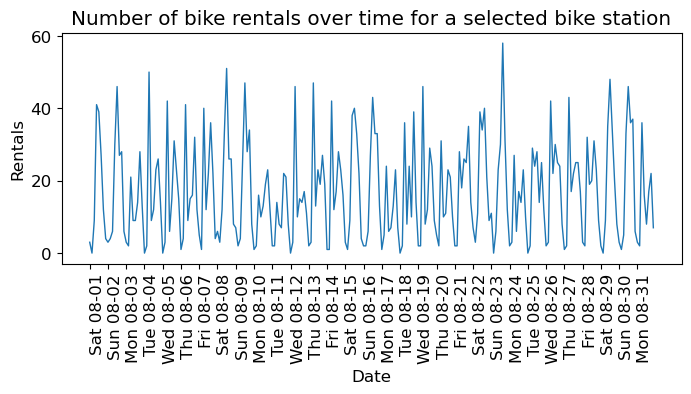

In [5]:
plt.figure(figsize=(8, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq="D")
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals");
plt.title("Number of bike rentals over time for a selected bike station");

- Questions you might want to answer: How many people are likely to rent a bike at this station in the next three hours given everything we know about rentals in the past? 
- We want to learn from the past and predict the future. 

### ❓❓ Questions for you

- Can we use our usual supervised machine learning methodology to predict the number of people who will rent bicycles from a specific station at a given time and date?
- How can you adapt traditional machine learning methods for time series forecasting?

## Train/test split for temporal data

- To evaluate the model's ability to generalize, we will divide the data into training and testing subsets.
- What will happen if we split this data the usual way?

In [6]:
train_df, test_df = train_test_split(citibike, test_size=0.2, random_state=123)

In [7]:
test_df.head()

starttime
2015-08-26 12:00:00    30
2015-08-12 09:00:00    10
2015-08-19 03:00:00     2
2015-08-07 12:00:00    22
2015-08-03 09:00:00     9
Name: one, dtype: int64

In [8]:
train_df.index.max(), test_df.index.min()

(Timestamp('2015-08-31 21:00:00'), Timestamp('2015-08-01 12:00:00'))

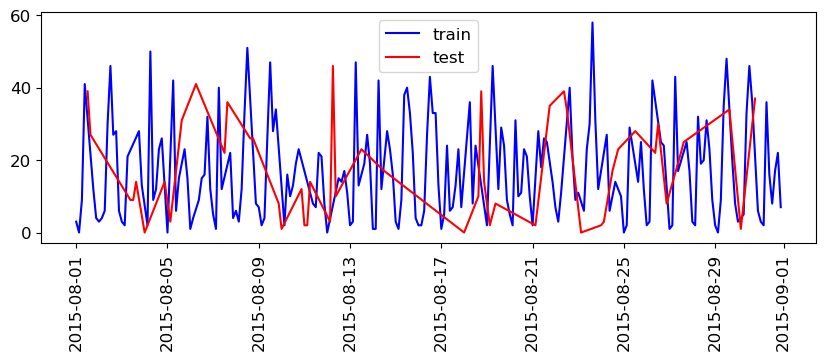

In [9]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

- So, we are training on data that came after our test data!
- If we want to forecast, **we aren't allowed to know what happened in the future**!
- There may be cases where this is OK, e.g. if you aren't trying to forecast and just want to understand your data (maybe you're not even splitting).
- But, for our purposes, we want to avoid this.

We'll split the data as follows:

- We have total 248 data points. 
- We'll use the fist 184 data points corresponding to the first 23 days as training data - And the remaining 64 data points corresponding to the remaining 8 days as test data. 

In [10]:
n_train = 184
train_df = citibike[:184]
test_df = citibike[184:]

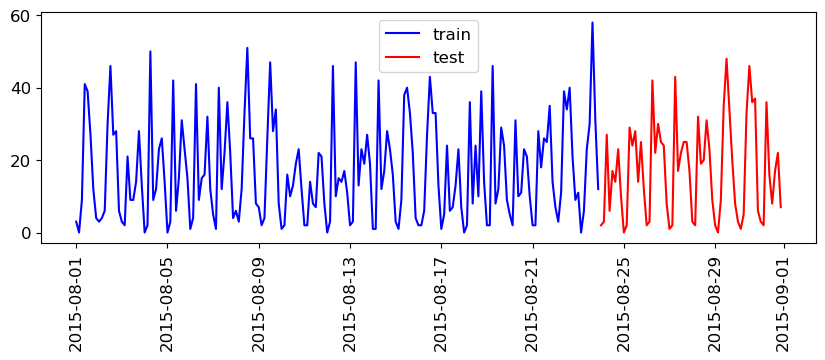

In [11]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

### ❓❓ Questions for you

- What kind of features would you create from time series data to use in a model like a random forest or SVM?

## Feature engineering for date/time columns

### POSIX time feature
- In this toy data, we just have a single feature: the date time feature. 
- We need to encode this feature if we want to build machine learning models. 
- A common way that dates are stored on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00 (this is beginning of Unix time). 
- Let's start with encoding this feature as a single integer representing this POSIX time. 

In [12]:
y_train = train_df.values
y_test = test_df.values
# convert to POSIX time by dividing by 10**9
X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9

In [13]:
X_train[:10]

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400],
       [1438441200],
       [1438452000],
       [1438462800],
       [1438473600],
       [1438484400]])

In [14]:
y_train[:10]

array([ 3,  0,  9, 41, 39, 27, 12,  4,  3,  4])

Our prediction task is a regression task. 

- Let's try random forest regression with just this feature. 
- We'll be trying out many different features. So we'll be using the function below which
    - Splits the data 
    - Trains the given regressor model on the training data
    - Shows train and test scores
    - Plots the predictions on the train and test data

In [15]:
# Code credit: Adapted from 
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/

def eval_on_features(features, target, regressor, n_train = 184, sales_data=False, ylabel='Rentals', feat_names="Default"):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    if not sales_data: 
        plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
        
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label="test")
    plt.plot(range(n_train), y_pred_train, "--", label="prediction train")

    plt.plot(
        range(n_train, len(y_test) + n_train), y_pred, "--", label="prediction test"
    )
    title = regressor.__class__.__name__ + "\n Features= " + feat_names
    plt.title(title)
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)

Train-set R^2: 0.85
Test-set R^2: -0.04


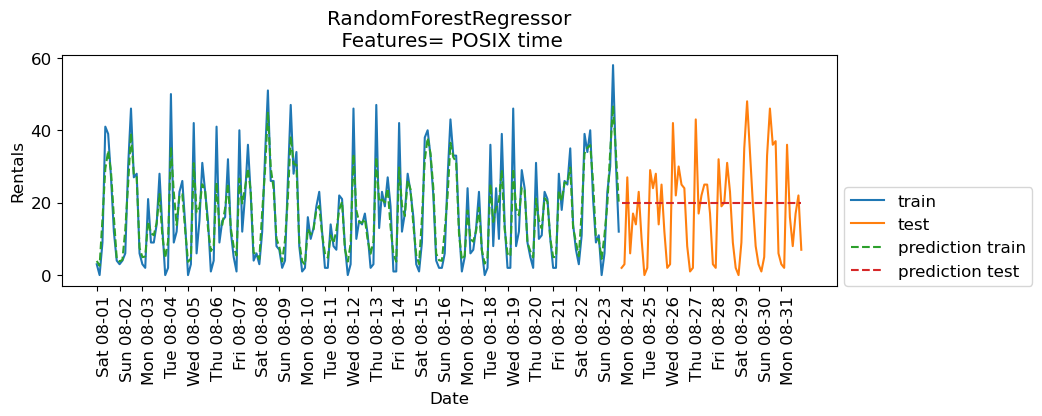

In [16]:
from sklearn.ensemble import RandomForestRegressor

X = (
    citibike.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
)  # convert to POSIX time by dividing by 10**9
y = citibike.values

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor, feat_names="POSIX time")

- The predictions on the training score is pretty good 
- But for the test data, a constant line is predicted ...
- What's going on? 

- The model is based on only one feature: POSIX time feature. 
- And the value of the POSIX time feature is outside the range of the feature values in the training set. 
- Tree-based models cannot _extrapolate_ to feature ranges outside the training data. 
- The model predicted the target value of the closest point in the training set. 

Can we come up with better features?

### Extracting date and time information

Note that our index is of this special type: [`DateTimeIndex`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html). We can extract all kinds of interesting information from it.   

In [17]:
citibike.index

DatetimeIndex(['2015-08-01 00:00:00', '2015-08-01 03:00:00',
               '2015-08-01 06:00:00', '2015-08-01 09:00:00',
               '2015-08-01 12:00:00', '2015-08-01 15:00:00',
               '2015-08-01 18:00:00', '2015-08-01 21:00:00',
               '2015-08-02 00:00:00', '2015-08-02 03:00:00',
               ...
               '2015-08-30 18:00:00', '2015-08-30 21:00:00',
               '2015-08-31 00:00:00', '2015-08-31 03:00:00',
               '2015-08-31 06:00:00', '2015-08-31 09:00:00',
               '2015-08-31 12:00:00', '2015-08-31 15:00:00',
               '2015-08-31 18:00:00', '2015-08-31 21:00:00'],
              dtype='datetime64[ns]', name='starttime', length=248, freq='3H')

In [18]:
citibike.index.month_name()

Index(['August', 'August', 'August', 'August', 'August', 'August', 'August',
       'August', 'August', 'August',
       ...
       'August', 'August', 'August', 'August', 'August', 'August', 'August',
       'August', 'August', 'August'],
      dtype='object', name='starttime', length=248)

In [19]:
citibike.index.dayofweek

Index([5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       ...
       6, 6, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype='int32', name='starttime', length=248)

In [20]:
citibike.index.day_name()

Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Sunday', 'Sunday',
       ...
       'Sunday', 'Sunday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object', name='starttime', length=248)

In [21]:
citibike.index.hour

Index([ 0,  3,  6,  9, 12, 15, 18, 21,  0,  3,
       ...
       18, 21,  0,  3,  6,  9, 12, 15, 18, 21],
      dtype='int32', name='starttime', length=248)

Let's first add the time of the day. 

In [22]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_hour[:10]

array([[ 0],
       [ 3],
       [ 6],
       [ 9],
       [12],
       [15],
       [18],
       [21],
       [ 0],
       [ 3]], dtype=int32)

Train-set R^2: 0.50
Test-set R^2: 0.60


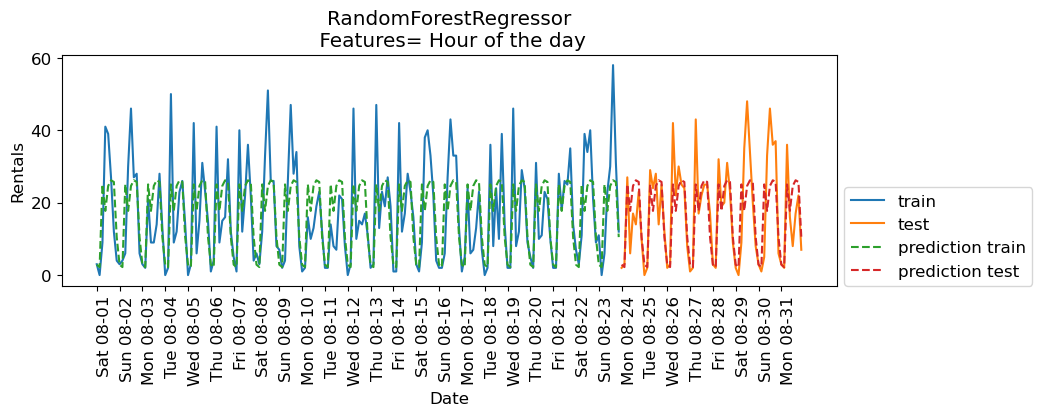

In [23]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour, y, regressor, feat_names = "Hour of the day")

Now let's add day of the week along with time of the day. 

Train-set R^2: 0.89
Test-set R^2: 0.84


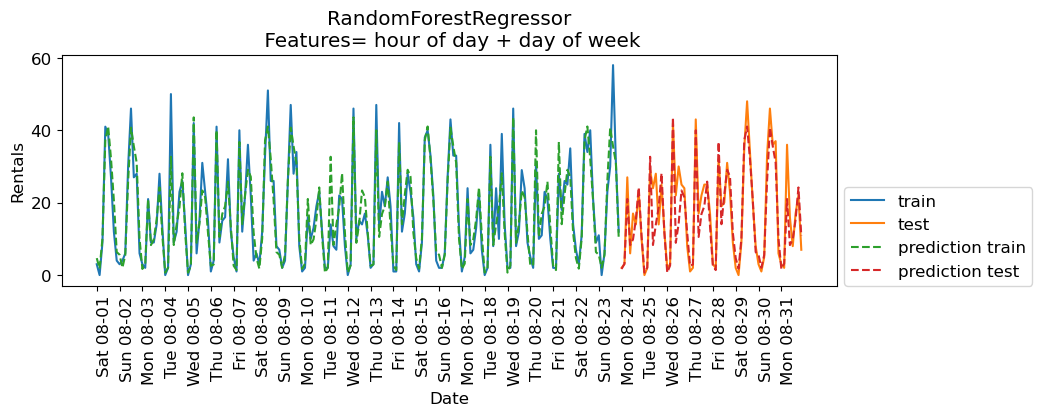

In [24]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
X_hour_week = np.hstack(
    [
        citibike.index.dayofweek.values.reshape(-1, 1),
        citibike.index.hour.values.reshape(-1, 1),
    ]
)
eval_on_features(X_hour_week, y, regressor, feat_names = "hour of day + day of week")

Train-set R^2: 0.16
Test-set R^2: 0.13


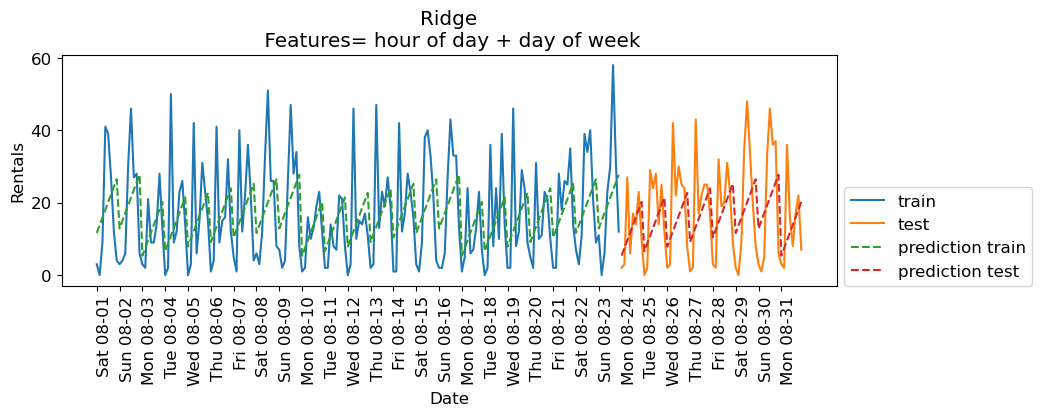

In [25]:
from sklearn.linear_model import Ridge

lr = Ridge();
eval_on_features(X_hour_week, y, lr, feat_names = "hour of day + day of week")

### ❓❓ Questions for you

Why is `Ridge` performing poorly on the training data as well as test data? 

### Encoding time of day as a categorical feature

- `Ridge` is performing poorly because it's not able to capture the periodic pattern.
- The reason is that we have encoded time of day using integers. 
- A linear function can only learn a linear function of the time of day. 
- What if we encode this feature as a categorical variable? 

In [26]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

In [27]:
X_hour_week_onehot
X_hour_week_onehot.shape

(248, 15)

In [28]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

In [29]:
pd.DataFrame(X_hour_week_onehot, columns=features)

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,00:00,03:00,06:00,09:00,12:00,15:00,18:00,21:00
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train-set R^2: 0.53
Test-set R^2: 0.62


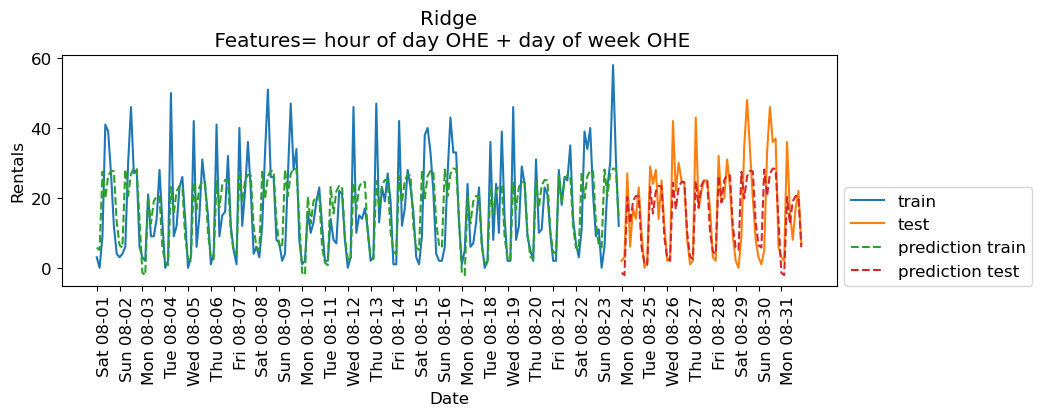

In [30]:
eval_on_features(X_hour_week_onehot, y, Ridge(), feat_names="hour of day OHE + day of week OHE")

- The scores are a bit better now. 
- What if we add interaction features (e.g., something like Day == Mon and hour == 9:00)
- We can do it using `sklearn`'s `PolynomialFeatures` transformer. 

In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(
    interaction_only=True, include_bias=False
)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

In [32]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour
features_poly = poly_transformer.get_feature_names_out(features)
features_poly

array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', '00:00', '03:00',
       '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', 'Mon Tue',
       'Mon Wed', 'Mon Thu', 'Mon Fri', 'Mon Sat', 'Mon Sun', 'Mon 00:00',
       'Mon 03:00', 'Mon 06:00', 'Mon 09:00', 'Mon 12:00', 'Mon 15:00',
       'Mon 18:00', 'Mon 21:00', 'Tue Wed', 'Tue Thu', 'Tue Fri',
       'Tue Sat', 'Tue Sun', 'Tue 00:00', 'Tue 03:00', 'Tue 06:00',
       'Tue 09:00', 'Tue 12:00', 'Tue 15:00', 'Tue 18:00', 'Tue 21:00',
       'Wed Thu', 'Wed Fri', 'Wed Sat', 'Wed Sun', 'Wed 00:00',
       'Wed 03:00', 'Wed 06:00', 'Wed 09:00', 'Wed 12:00', 'Wed 15:00',
       'Wed 18:00', 'Wed 21:00', 'Thu Fri', 'Thu Sat', 'Thu Sun',
       'Thu 00:00', 'Thu 03:00', 'Thu 06:00', 'Thu 09:00', 'Thu 12:00',
       'Thu 15:00', 'Thu 18:00', 'Thu 21:00', 'Fri Sat', 'Fri Sun',
       'Fri 00:00', 'Fri 03:00', 'Fri 06:00', 'Fri 09:00', 'Fri 12:00',
       'Fri 15:00', 'Fri 18:00', 'Fri 21:00', 'Sat Sun', 'Sat 00:00',
       'Sat 03:00

In [33]:
pd.DataFrame(X_hour_week_onehot_poly, columns = features_poly)

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,00:00,03:00,06:00,...,09:00 12:00,09:00 15:00,09:00 18:00,09:00 21:00,12:00 15:00,12:00 18:00,12:00 21:00,15:00 18:00,15:00 21:00,18:00 21:00
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train-set R^2: 0.87
Test-set R^2: 0.85


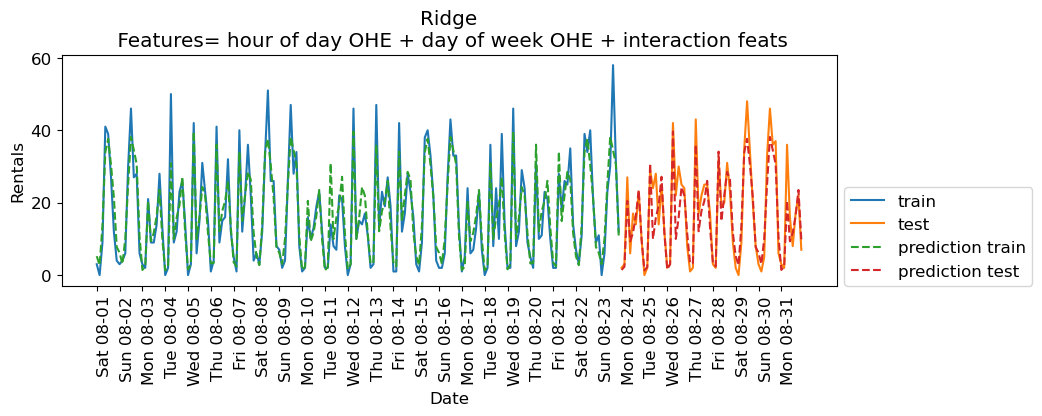

In [34]:
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr, feat_names = "hour of day OHE + day of week OHE + interaction feats")

Let's examine the coefficients learned by `Ridge`.

In [35]:
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [36]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

,Coefficient
Sat 09:00,15.196739
Wed 06:00,15.005809
Sat 12:00,13.437684
Sun 12:00,13.362009
Thu 06:00,10.907595
...,...
Sat 21:00,-6.085150
00:00,-11.693898
03:00,-12.111220
Sat 06:00,-13.757591


### Interim summary

- Success in time-series analysis heavily relies on the appropriate choice of models and features.
- Tree-based models cannot extrapolate; caution is needed when using them with linear integer features.
- Linear models struggle with cyclic patterns in numeric features (e.g., numerically encoded time of the day feature) because these patterns are inherently non-linear.
- Applying one-hot encoding on such features transforms cyclic temporal features into a format where their impact on the target variable can be independently and linearly modeled, enabling linear models to effectively capture and use these cyclic patterns. 

### Lag-based features

- So far we engineered some features and managed to get reasonable results. 
- In time series data there is temporal dependence; observations close in time tend to be correlated. 
- Currently we're using current time to predict the number of bike rentals at that time. 
- But, what if the number of bike rentals is also related to bike rentals three hours ago or 6 hours ago and so on? 
  - Such features are called _lagged_ features.  
  
_Note: In time series analysis, you would look at something called an [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF), but we won't go into that here._ 

Let's extract lag features. We can "lag" (or "shift") a time series in Pandas with the `.shift()` method.

In [37]:
rentals_df = pd.DataFrame(citibike)
rentals_df = rentals_df.rename(columns={"one":"n_rentals"})
rentals_df.head(n=6)

,n_rentals
starttime,
2015-08-01 00:00:00,3
2015-08-01 03:00:00,0
2015-08-01 06:00:00,9
2015-08-01 09:00:00,41
2015-08-01 12:00:00,39
2015-08-01 15:00:00,27


In [38]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [39]:
rentals_lag5 = create_lag_df(rentals_df, 5, ['n_rentals'] )
rentals_lag5.head(n=6)

,n_rentals,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,,
2015-08-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN
2015-08-01 03:00:00,0,3.0,NaN,NaN,NaN,NaN
2015-08-01 06:00:00,9,0.0,3.0,NaN,NaN,NaN
2015-08-01 09:00:00,41,9.0,0.0,3.0,NaN,NaN
2015-08-01 12:00:00,39,41.0,9.0,0.0,3.0,NaN
2015-08-01 15:00:00,27,39.0,41.0,9.0,0.0,3.0


- Note the NaN pattern. 
- We can either drop the first 5 rows or apply imputation. 
- Let's try these features with Ridge model. 

In [40]:
X_lag_features = rentals_lag5.drop(columns = ['n_rentals']).to_numpy()
X_lag_features

array([[nan, nan, nan, nan, nan],
       [ 3., nan, nan, nan, nan],
       [ 0.,  3., nan, nan, nan],
       ...,
       [ 8., 16., 36.,  2.,  3.],
       [17.,  8., 16., 36.,  2.],
       [22., 17.,  8., 16., 36.]])

Train-set R^2: 0.26
Test-set R^2: 0.37


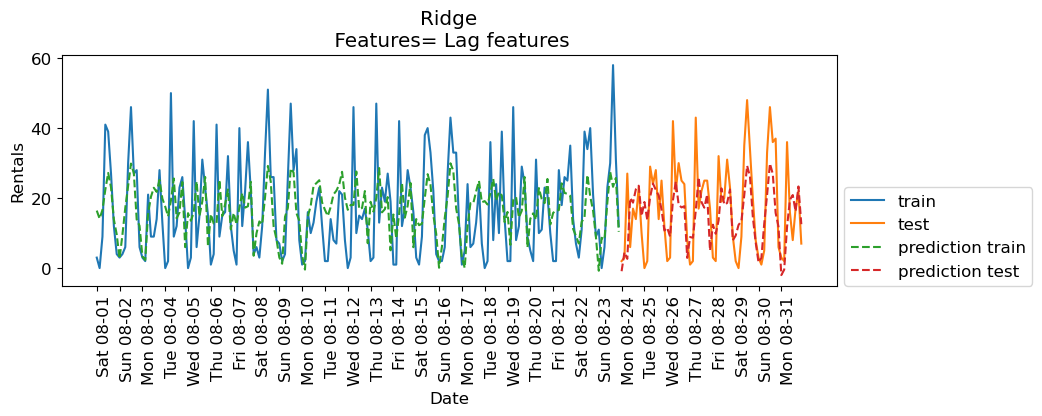

In [41]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)
lr = Ridge()
eval_on_features(X_lag_features_imp, y, lr, feat_names="Lag features")

In [42]:
features_lag = rentals_lag5.drop(columns=['n_rentals']).columns.tolist()
features_nonzero = np.array(features_lag)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [43]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

,Coefficient
n_rentals-1,0.165145
n_rentals-4,-0.049007
n_rentals-2,-0.215227
n_rentals-3,-0.258891
n_rentals-5,-0.373974


How about `RandomForestRegressor` model? 

Train-set R^2: 0.95
Test-set R^2: 0.69


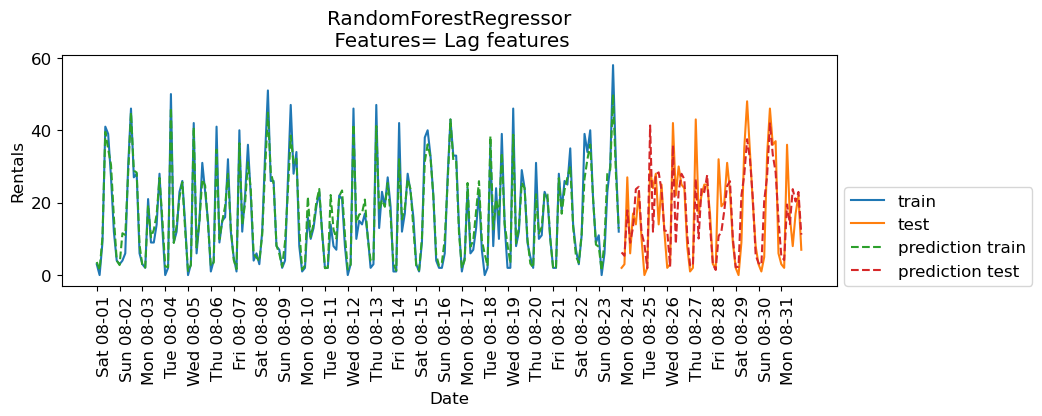

In [44]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)
rf = RandomForestRegressor()
eval_on_features(X_lag_features_imp, y, rf, feat_names="Lag features")

In [45]:
X_hour_week_onehot_poly_lag = np.hstack([X_hour_week_onehot_poly, X_lag_features_imp])

Train-set R^2: 0.96
Test-set R^2: 0.79


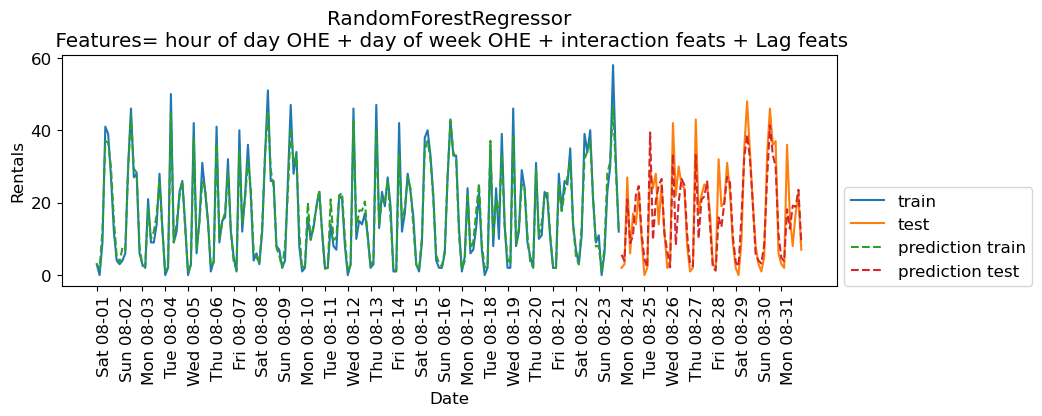

In [46]:
rf = RandomForestRegressor()
eval_on_features(X_hour_week_onehot_poly_lag, y, rf, feat_names = "hour of day OHE + day of week OHE + interaction feats + Lag feats")

Some improvement but we are getting better results without the lag features in this case. 

### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- If you carry out regular cross-validation, you'll be predicting the past given future which is not a realistic scenario for the deployment data. 

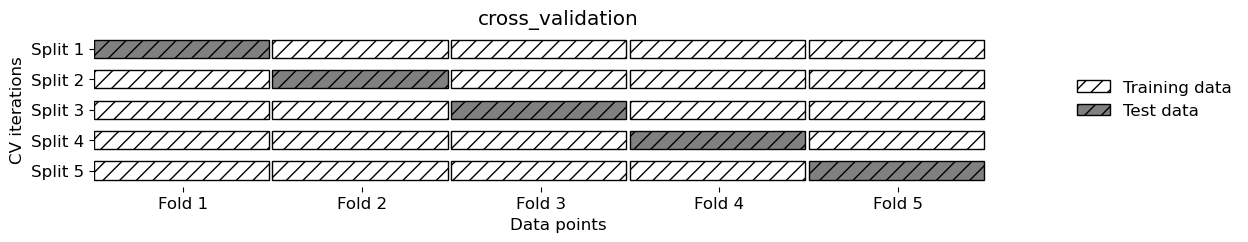

In [47]:
mglearn.plots.plot_cross_validation()

There is [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for time series data. 

In [48]:
from sklearn.model_selection import TimeSeriesSplit

# Code from sklearn documentation
X_toy = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_toy = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X_toy):
    print("%s %s" % (train, test))

[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


In [49]:
lr = Ridge()
scores = cross_validate(
    lr, X_hour_week_onehot_poly, y, cv=TimeSeriesSplit(), return_train_score=True
)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000827,0.000422,0.642676,0.873182
1,0.001050,0.000872,0.828405,0.874305
2,0.003621,0.001182,0.773851,0.901262
3,0.008621,0.001251,0.696712,0.889429
4,0.004450,0.001029,0.892733,0.863889


## Forecasting further into the future

Recall that we are working with the bike rentals data from August 2015. 

In [50]:
citibike

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3H, Name: one, Length: 248, dtype: int64

Here is our data with lag features.

In [51]:
rentals_lag5

,n_rentals,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,,
2015-08-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN
2015-08-01 03:00:00,0,3.0,NaN,NaN,NaN,NaN
2015-08-01 06:00:00,9,0.0,3.0,NaN,NaN,NaN
2015-08-01 09:00:00,41,9.0,0.0,3.0,NaN,NaN
2015-08-01 12:00:00,39,41.0,9.0,0.0,3.0,NaN
...,...,...,...,...,...,...
2015-08-31 09:00:00,16,36.0,2.0,3.0,6.0,37.0
2015-08-31 12:00:00,8,16.0,36.0,2.0,3.0,6.0
2015-08-31 15:00:00,17,8.0,16.0,36.0,2.0,3.0


Let's impute the data and create `X` and `y`

In [52]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)

In [53]:
rentals_lag5_X = pd.DataFrame(X_lag_features_imp, columns=rentals_lag5.drop(columns=['n_rentals']).columns)
rentals_lag5_X.index = rentals_lag5.index
rentals_lag5_y = rentals_lag5['n_rentals']
rentals_lag5_X

,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,
2015-08-01 00:00:00,17.024291,17.004065,17.004082,17.040984,17.045267
2015-08-01 03:00:00,3.000000,17.004065,17.004082,17.040984,17.045267
2015-08-01 06:00:00,0.000000,3.000000,17.004082,17.040984,17.045267
2015-08-01 09:00:00,9.000000,0.000000,3.000000,17.040984,17.045267
2015-08-01 12:00:00,41.000000,9.000000,0.000000,3.000000,17.045267
...,...,...,...,...,...
2015-08-31 09:00:00,36.000000,2.000000,3.000000,6.000000,37.000000
2015-08-31 12:00:00,16.000000,36.000000,2.000000,3.000000,6.000000
2015-08-31 15:00:00,8.000000,16.000000,36.000000,2.000000,3.000000


Let's split the data and train a linear model.

In [54]:
# split the given features into a training and a test set
n_train = 184
X_train, X_test = rentals_lag5_X[:n_train], rentals_lag5_X[n_train:]
# also split the target array
y_train, y_test = rentals_lag5_y[:n_train], rentals_lag5_y[n_train:]

In [55]:
rentals_model = RandomForestRegressor(random_state=42)
rentals_model.fit(X_train, y_train);
print("Train-set R^2: {:.2f}".format(rentals_model.score(X_train, y_train)))
print("Test-set R^2: {:.2f}".format(rentals_model.score(X_test, y_test)))

Train-set R^2: 0.94
Test-set R^2: 0.68


Given this, we can now predict `n_rentals` on the test data.

In [56]:
X_test.head(n=5)

,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5
starttime,,,,,
2015-08-24 00:00:00,12.0,31.0,58.0,30.0,23.0
2015-08-24 03:00:00,2.0,12.0,31.0,58.0,30.0
2015-08-24 06:00:00,3.0,2.0,12.0,31.0,58.0
2015-08-24 09:00:00,27.0,3.0,2.0,12.0,31.0
2015-08-24 12:00:00,6.0,27.0,3.0,2.0,12.0


In [57]:
preds = rentals_model.predict(X_test)
preds

array([ 6.36,  4.73, 16.84,  8.71, 13.  , 24.34, 23.91, 12.07,  5.44,
        2.11, 42.31, 11.64, 28.09, 26.46, 25.41, 12.28, 11.89,  2.01,
       34.5 ,  8.34, 23.94, 25.2 , 26.63, 11.02,  2.67,  2.71, 26.72,
        9.96, 24.42, 23.05, 26.79, 14.17,  3.22,  1.51,  9.15,  8.83,
       21.12, 24.7 , 25.23, 10.04,  2.21,  2.29, 22.45, 28.03, 36.14,
       32.83, 21.45,  5.8 ,  3.43,  3.18, 21.72, 26.23, 40.37, 34.84,
       27.67, 14.79,  5.44,  4.45, 20.19, 14.49, 23.06, 20.34, 23.02,
       10.11])

In [58]:
X_test_preds = X_test.assign(predicted_n_rentals=preds)
X_test_preds = X_test_preds.assign(n_rentals=y_test)
X_test_preds.tail()

,n_rentals-1,n_rentals-2,n_rentals-3,n_rentals-4,n_rentals-5,predicted_n_rentals,n_rentals
starttime,,,,,,,
2015-08-31 09:00:00,36.0,2.0,3.0,6.0,37.0,14.49,16
2015-08-31 12:00:00,16.0,36.0,2.0,3.0,6.0,23.06,8
2015-08-31 15:00:00,8.0,16.0,36.0,2.0,3.0,20.34,17
2015-08-31 18:00:00,17.0,8.0,16.0,36.0,2.0,23.02,22
2015-08-31 21:00:00,22.0,17.0,8.0,16.0,36.0,10.11,7


- Ok, that is fine, but what if we want to predict 15 hours in the future? In other words, what if we want to predict number of rentals for the next three hours at time 2015-09-01 12:00:00?   
- Well, we would not have access to our lag features!! We don't yet know `n_rentals` for
    - 2015-09-01 00:00:00
    - 2015-09-01 03:00:00
    - 2015-09-01 06:00:00
    - 2015-09-01 09:00:00

There are a few approaches which could be employed:
1. Train a separate model for each number of 3-hour span. E.g. one model that predicts `n_rentals` for next three hours, another model that predicts `n_rentals` in six hours, etc. We can build these datasets.
2. Use a multi-output model that jointly predicts `n_rentalsIn3hours`, `n_rentalsIn6hours`, etc. However, multi-output models are outside the scope of CPSC 330. 
3. Use one model and sequentially predict using a `for` loop. 

If we decide to use approach 3, we would predict these values and then pretend they are true! For example, given that it's August 31st 2015 at 21:00. 

1. Predict `n_rentals` for September 1st 2015 at 00:00.
2. Then to predict `n_rentals` for September 1st 2015 at 03:00, we need to know `n_rentals` for September 1st 2015 at 00:00. Use our _prediction_ for September 1st 2015 at 00:00 as the truth.
3. Then, to predict `n_rentals` for September 1st 2015 at 06:00, we need to know `n_rentals` for September 1st 2015 at 00:00 and `n_rentals` for September 1st 2015 at 03:00. Use our predictions.
4. Etc etc.

### Forecasting further into the future on a retail dataset

Let's consider another time series dataset, [Retail Sales of Clothing and Clothing Accessory Stores dataset](https://fred.stlouisfed.org/series/MRTSSM448USN) which is made available by the Federal Reserve Bank of St. Louis.

The dataset has dates and retail sales values corresponding to the dates. 

In [59]:
retail_df = pd.read_csv("../data/MRTSSM448USN.csv", parse_dates=["DATE"])
retail_df.columns = ["date", "sales"]
retail_df.head()

,date,sales
0,1992-01-01,6938.0
1,1992-02-01,7524.0
2,1992-03-01,8475.0
3,1992-04-01,9401.0
4,1992-05-01,9558.0


In [60]:
retail_df["date"].min()

Timestamp('1992-01-01 00:00:00')

In [61]:
retail_df["date"].max()

Timestamp('2023-09-01 00:00:00')

I'm considering everything upto 01 January 2016 as training data and everything after that as test data. 

In [62]:
retail_df_train = retail_df.query("date <= 20160101")
retail_df_test = retail_df.query("date >  20160101")

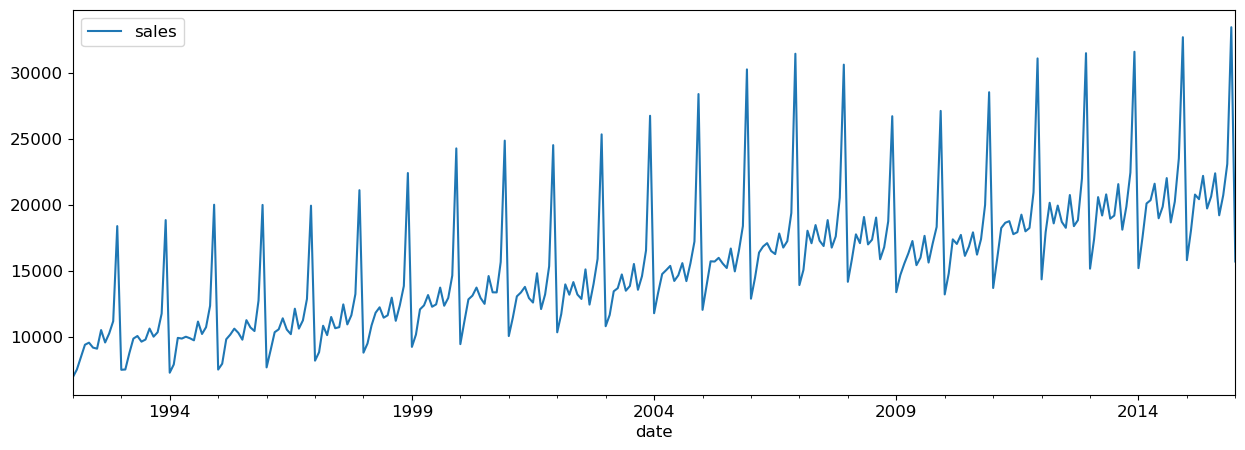

In [63]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

We can create a dataset using purely lag features.

In [64]:
def lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [65]:
retail_lag_5 = lag_df(retail_df, 5, ["sales"])
retail_train_5 = retail_lag_5.query("date <= 20160101")
retail_test_5 = retail_lag_5.query("date >  20160101")
retail_train_5

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5
0,1992-01-01,6938.0,NaN,NaN,NaN,NaN,NaN
1,1992-02-01,7524.0,6938.0,NaN,NaN,NaN,NaN
2,1992-03-01,8475.0,7524.0,6938.0,NaN,NaN,NaN
3,1992-04-01,9401.0,8475.0,7524.0,6938.0,NaN,NaN
4,1992-05-01,9558.0,9401.0,8475.0,7524.0,6938.0,NaN
...,...,...,...,...,...,...,...
284,2015-09-01,19215.0,22396.0,20637.0,19732.0,22203.0,20435.0
285,2015-10-01,20736.0,19215.0,22396.0,20637.0,19732.0,22203.0
286,2015-11-01,23108.0,20736.0,19215.0,22396.0,20637.0,19732.0
287,2015-12-01,33473.0,23108.0,20736.0,19215.0,22396.0,20637.0


- Now, if we drop the "date" column we have a target ("sales") and 5 features (the previous 5 days of sales).
- We need to impute/drop the missing values and then we can fit a model to this. I will just drop for convenience:

In [66]:
retail_train_5 = retail_train_5[5:].drop(columns=["date"])
retail_train_5

,sales,sales-1,sales-2,sales-3,sales-4,sales-5
5,9182.0,9558.0,9401.0,8475.0,7524.0,6938.0
6,9103.0,9182.0,9558.0,9401.0,8475.0,7524.0
7,10513.0,9103.0,9182.0,9558.0,9401.0,8475.0
8,9573.0,10513.0,9103.0,9182.0,9558.0,9401.0
9,10254.0,9573.0,10513.0,9103.0,9182.0,9558.0
...,...,...,...,...,...,...
284,19215.0,22396.0,20637.0,19732.0,22203.0,20435.0
285,20736.0,19215.0,22396.0,20637.0,19732.0,22203.0
286,23108.0,20736.0,19215.0,22396.0,20637.0,19732.0
287,33473.0,23108.0,20736.0,19215.0,22396.0,20637.0


In [67]:
retail_train_5_X = retail_train_5.drop(columns=["sales"])
retail_train_5_y = retail_train_5["sales"]

In [68]:
retail_model = RandomForestRegressor(random_state=42)
retail_model.fit(retail_train_5_X, retail_train_5_y);
print("Train-set R^2: {:.2f}".format(retail_model.score(retail_train_5_X, retail_train_5_y)))

Train-set R^2: 0.96


Given this, we can now predict the sales

In [69]:
preds = retail_model.predict(retail_test_5.drop(columns=["date", "sales"]))
preds

array([17834.56, 21806.4 , 21426.86, 21768.99, 21747.16, 20574.27,
       22117.31, 25778.21, 21360.38, 22280.77, 29877.71, 16119.89,
       18083.12, 20355.16, 21054.32, 22420.36, 21984.82, 21812.65,
       21685.98, 29346.98, 21467.61, 22010.34, 28491.91, 16128.05,
       17856.37, 21713.71, 22782.19, 22161.51, 28510.07, 21128.09,
       22131.92, 30014.02, 21443.91, 21672.53, 19116.99, 16119.89,
       18241.21, 20253.07, 22913.92, 22784.38, 28548.01, 22692.96,
       21514.99, 29618.12, 21429.14, 21544.21, 25183.48, 16119.89,
       18612.4 , 21756.48, 13100.66, 11038.16, 10901.73, 15185.61,
       13166.81, 11039.72, 18339.52, 21841.02, 23064.88, 14702.92,
       17546.49, 18476.18, 29886.68, 29351.99, 15859.61, 27861.74,
       24889.6 , 28100.51, 23781.35, 28971.92, 15870.95, 16298.35,
       19557.72, 22062.27, 17797.9 , 17486.87, 16497.21, 27922.19,
       28005.46, 17151.32, 29901.57, 28100.51, 15870.95, 16298.35,
       21477.84, 21868.26, 25671.1 , 27675.97, 16709.46, 27998

In [70]:
retail_test_5_preds = retail_test_5.assign(predicted_sales=preds)
retail_test_5_preds.tail()

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,predicted_sales
376,2023-05-01,26557.0,24700.0,24963.0,20937.0,19405.0,39883.0,27675.97
377,2023-06-01,24809.0,26557.0,24700.0,24963.0,20937.0,19405.0,16709.46
378,2023-07-01,25364.0,24809.0,26557.0,24700.0,24963.0,20937.0,27998.61
379,2023-08-01,27143.0,25364.0,24809.0,26557.0,24700.0,24963.0,18343.15
380,2023-09-01,23941.0,27143.0,25364.0,24809.0,26557.0,24700.0,16238.70


- Now what if we want to predict 5 months in the future? 
- We would not have access to our features!! We don't yet know the previous months sales, or two months prior! 

If we decide to use approach 3 from above, we would predict these values and then pretend they are true! For example, given that it's November 2022

1. Predict December 2022 sales
2. Then, to predict for January 2023, we need to know December 2022 sales. Use our _prediction_ for December 2022 as the truth.
3. Then, to predict for February 2023, we need to know December 2022 and January 2023 sales. Use our predictions.
4. Etc etc.

### Seasonality and trends 

- There are some important concepts in time series that rely on having a continuous target (like we do in the retail sales example above).
- Part of that is the idea of seasonality and trends.
- These are mostly taken care of by our feature engineering of the data variable, but there's something important left to discuss.

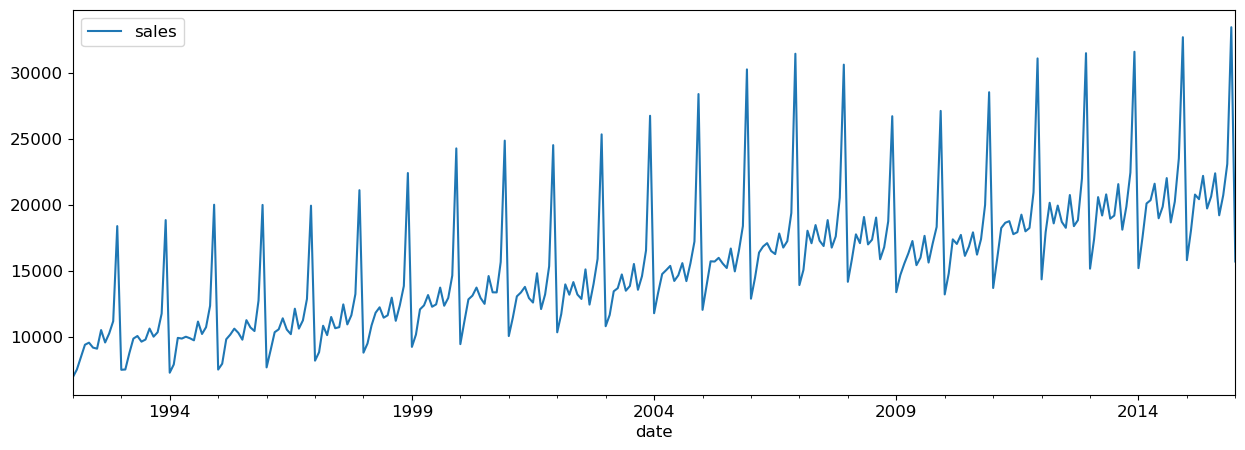

In [71]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

- It looks like there's a **trend** here - the sales are going up over time. 

Let's say we encoded the date as a feature in days like this:

In [72]:
retail_train_5_date = retail_lag_5.query("date <= 20160101")
first_day_retail = retail_train_5_date["date"].min()

retail_train_5_date = retail_train_5_date.assign(
    Days_since=retail_train_5_date["date"].apply(lambda x: (x - first_day_retail).days)
)
retail_train_5_date.head(10)

,date,sales,sales-1,sales-2,sales-3,sales-4,sales-5,Days_since
0,1992-01-01,6938.0,NaN,NaN,NaN,NaN,NaN,0
1,1992-02-01,7524.0,6938.0,NaN,NaN,NaN,NaN,31
2,1992-03-01,8475.0,7524.0,6938.0,NaN,NaN,NaN,60
3,1992-04-01,9401.0,8475.0,7524.0,6938.0,NaN,NaN,91
4,1992-05-01,9558.0,9401.0,8475.0,7524.0,6938.0,NaN,121
5,1992-06-01,9182.0,9558.0,9401.0,8475.0,7524.0,6938.0,152
6,1992-07-01,9103.0,9182.0,9558.0,9401.0,8475.0,7524.0,182
7,1992-08-01,10513.0,9103.0,9182.0,9558.0,9401.0,8475.0,213
8,1992-09-01,9573.0,10513.0,9103.0,9182.0,9558.0,9401.0,244
9,1992-10-01,10254.0,9573.0,10513.0,9103.0,9182.0,9558.0,274


- Now, let's say we use all these features (the lagged version of the target and also `Days_since`.
- If we use **linear regression** we'll learn a coefficient for `Days_since`. 
  - If that coefficient is positive, it predicts unlimited growth forever. That may not be what you want? It depends.
- If we use a **random forest**, we'll just be doing splits from the training set, e.g. "if `Days_since` > 9100 then do this".
  - There will be no splits for later time points because there is no training data there.
  - Thus tree-based models cannot model trends.
  - This is really important to know!!
- Often, we model the trend separately and use the random forest to model a de-trended time series.

## Demo: A more complicated dataset

[Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset. Predicting whether or not it will rain tomorrow based on today's measurements.

In [73]:
rain_df = pd.read_csv("../data/weatherAUS.csv")
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [74]:
rain_df.shape

(145460, 23)

**Questions of interest**

- Can we **forecast** into the future? Can we predict whether it's going to rain tomorrow?
    - The target variable is `RainTomorrow`. The target is categorical and not continuous in this case. 
- Can the date/time features help us predict the target value?

### Exploratory data analysis

In [75]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [76]:
rain_df.describe(include="all")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


- A number of missing values. 
- Some target values are also missing. I'm dropping these rows. 

In [77]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

### Parsing datetimes 

- In general, datetimes are a huge pain! 
    - Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [78]:
dates_rain = pd.to_datetime(rain_df["Date"])
dates_rain

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145454   2017-06-20
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

They are all the same format, so we can also compare dates:

In [79]:
dates_rain[1] - dates_rain[0]

Timedelta('1 days 00:00:00')

In [80]:
dates_rain[1] > dates_rain[0]

True

In [81]:
(dates_rain[1] - dates_rain[0]).total_seconds()

86400.0

We can also easily extract information from the date columns.

In [82]:
dates_rain[1]

Timestamp('2008-12-02 00:00:00')

In [83]:
dates_rain[1].month_name()

'December'

In [84]:
dates_rain[1].is_leap_year

True

Above pandas identified the date column automatically. You can tell pandas to parse the dates when reading in the CSV:

In [85]:
rain_df = pd.read_csv("../data/weatherAUS.csv", parse_dates=["Date"])
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [86]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

In [87]:
rain_df.sort_values(by="Date").head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


In [88]:
rain_df.sort_values(by="Date").tail()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
39537,2017-06-25,WaggaWagga,-0.1,12.7,0.0,NaN,NaN,SSW,19.0,SSW,...,92.0,54.0,1020.8,1018.5,8.0,8.0,4.0,10.7,No,No
33519,2017-06-25,Sydney,7.6,19.3,0.0,3.4,9.4,W,35.0,W,...,73.0,32.0,1018.6,1015.4,1.0,1.0,9.4,18.8,No,No
30175,2017-06-25,Richmond,2.7,20.0,0.2,NaN,NaN,W,37.0,NaN,...,88.0,35.0,1018.8,1015.2,NaN,NaN,9.6,19.4,No,No
27166,2017-06-25,Penrith,3.1,20.0,0.0,NaN,NaN,SW,28.0,SE,...,95.0,45.0,NaN,NaN,NaN,NaN,7.8,17.8,No,No
36528,2017-06-25,SydneyAirport,6.8,19.5,0.0,3.4,9.4,WSW,46.0,NW,...,67.0,42.0,1018.4,1015.2,1.0,1.0,11.9,17.9,No,No


### ❓❓ Questions for you
How many time series are present in this dataset?

We definitely see measurements on the same day at different locations. 

In [89]:
rain_df.sort_values(by=["Location", "Date"]).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
96320,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,NW,48.0,SW,...,92.0,67.0,1017.4,1017.7,NaN,NaN,13.5,14.9,Yes,No
96321,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,SW,35.0,SSW,...,75.0,52.0,1022.4,1022.6,NaN,NaN,13.7,15.5,No,No
96322,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,W,20.0,NNE,...,81.0,56.0,1027.8,1026.5,NaN,NaN,9.3,13.9,No,No
96323,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,NNE,30.0,NNE,...,71.0,46.0,1028.7,1025.6,NaN,NaN,10.2,15.3,No,No
96325,2008-07-06,Adelaide,11.3,15.7,NaN,NaN,1.5,NNW,52.0,NNE,...,62.0,62.0,1019.5,1016.2,NaN,NaN,13.0,14.4,NaN,Yes


Great! Now we gave a sequence of dates with single row per date. We have a separate timeseries for each region. 

Do we have equally spaced measurements?

In [90]:
count = 0 
for name, group in rain_df.groupby(['Location']):
    print("%-30s %s" % (name, group["Date"].sort_values().diff().value_counts()))
    print('\n\n\n')
    count+=1
    if count == 2: 
        break

('Adelaide',)                  Date
1 days     3016
2 days       42
3 days       24
4 days        4
31 days       1
32 days       1
29 days       1
Name: count, dtype: int64




('Albany',)                    Date
1 days     2993
2 days       15
3 days        4
31 days       1
33 days       1
29 days       1
Name: count, dtype: int64






The typical spacing seems to be 1 day for each location but there are several exceptions. We seem to have several missing measurements.   

### Train/test splits

Remember that we should not be calling the usual `train_test_split` with shuffling because if we want to forecast, we aren't allowed to know what happened in the future!

In [91]:
rain_df["Date"].min()

Timestamp('2007-11-01 00:00:00')

In [92]:
rain_df["Date"].max()

Timestamp('2017-06-25 00:00:00')

- It looks like we have 10 years of data.
- Let's use the last 2 years for test.

In [93]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [94]:
len(train_df), len(test_df), len(test_df) / (len(train_df) + len(test_df))

(107502, 34691, 0.24397122221206388)

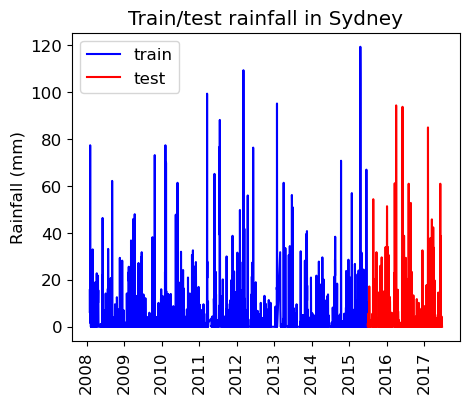

In [95]:
train_df_sort = train_df.query("Location == 'Sydney'").sort_values(by="Date")
test_df_sort = test_df.query("Location == 'Sydney'").sort_values(by="Date")

plt.figure(figsize=(5,4))
plt.plot(train_df_sort["Date"], train_df_sort["Rainfall"], "b", label="train")
plt.plot(test_df_sort["Date"], test_df_sort["Rainfall"], "r", label="test")
plt.xticks(rotation="vertical")
plt.legend()
plt.ylabel("Rainfall (mm)")
plt.title("Train/test rainfall in Sydney");

We're learning relationships from the blue part; predicting only using features in the red part from the day before.

### Preprocessing

We have different types of features. So let's define a preprocessor with a column transformer. 

In [96]:
train_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


- We have missing data. 
- We have categorical features and numeric features.

- Let's define feature types. 
- Let's start with dropping the date column and treating it as a usual supervised machine learning problem. 

In [97]:
numeric_features = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
]
categorical_features = [
    "Location",
    "WindGustDir",
    "WindDir9am",
    "WindDir3pm",
    "RainToday",
]
drop_features = ["Date"]
target = ["RainTomorrow"]

In [98]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["RainTomorrow"]
    y_test = test_df["RainTomorrow"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [99]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features, target
)

In [100]:
X_train_enc.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_missing,RainToday_No,RainToday_Yes,RainToday_missing
0,0.204302,-0.027112,-0.205323,-0.140641,0.160729,0.298612,0.666166,0.599894,0.115428,-1.433514,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.741037,0.287031,-0.275008,-0.140641,0.160729,0.298612,-1.125617,0.373275,-1.314929,-1.288002,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.125523,0.372706,-0.275008,-0.140641,0.160729,0.450132,0.554180,0.826513,-1.632786,-1.045481,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.457435,0.701128,-0.275008,-0.140641,0.160729,-1.216596,-0.341712,-1.099749,-1.261953,-1.724539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.850283,1.315134,-0.158867,-0.140641,0.160729,0.071330,-0.789657,0.146656,0.698167,-0.899969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### `DummyClassifier`

In [101]:
dc = DummyClassifier()
dc.fit(train_df, y_train);

In [102]:
dc.score(train_df, y_train)

0.7750553478074826

In [103]:
y_train.value_counts()

RainTomorrow
No     83320
Yes    24182
Name: count, dtype: int64

In [104]:
dc.score(test_df, y_test)

0.7781845435415525

### LogisticRegression

In [105]:
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["logisticregression"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [106]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.243188
RainToday_missing,0.925305
Pressure9am,0.865451
Location_Witchcliffe,0.729055
WindGustSpeed,0.720420
...,...
Location_Townsville,-0.718789
Location_Katherine,-0.726280
Location_Wollongong,-0.748698
Location_MountGinini,-0.964779


### Cross-validation

- We can carry out cross-validation using [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split). 
- However, things are actually more complicated here because this dataset has **multiple time series**, one per location. 

In [107]:
train_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144729,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,73.0,37.0,1031.5,1027.6,NaN,NaN,8.8,17.2,No,No
144730,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,69.0,40.0,1029.9,1026.0,NaN,NaN,7.0,15.7,No,No
144731,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,69.0,39.0,1028.7,1025.0,NaN,3.0,8.9,18.0,No,No
144732,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,67.0,37.0,1027.2,1023.8,6.0,7.0,11.7,21.5,No,No


In [108]:
train_df.sort_values(by=["Date", "Location"]).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


- The dataframe is sorted by location and then time. 
- Our approach today will be to ignore the fact that we have multiple time series and just OHE the location
- We'll have multiple measurements for a given timestamp, and that's OK.
- But, `TimeSeriesSplit` expects the dataframe to be sorted by date so...

In [109]:
train_df_ordered = train_df.sort_values(by=["Date"])
y_train_ordered = train_df_ordered["RainTomorrow"]

In [110]:
train_df_ordered

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57415,2015-06-30,Ballarat,-0.3,10.5,0.0,NaN,NaN,S,26.0,NaN,...,99.0,63.0,1029.5,1027.7,NaN,8.0,4.7,9.3,No,No
119911,2015-06-30,PerthAirport,10.1,23.5,0.0,3.2,5.8,NNE,31.0,NE,...,48.0,33.0,1023.6,1021.7,7.0,6.0,13.3,22.2,No,No
60455,2015-06-30,Bendigo,0.3,11.4,0.0,NaN,NaN,W,19.0,NaN,...,89.0,56.0,1029.3,1027.4,8.0,7.0,6.4,10.5,No,No
66473,2015-06-30,MelbourneAirport,3.2,13.2,0.0,0.8,3.9,N,20.0,N,...,91.0,50.0,1029.6,1027.3,2.0,7.0,5.3,11.9,No,No


In [111]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
cross_val_score(lr_pipe, train_df_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

0.8478763185801196

### Feature engineering: Encoding date/time as feature(s)
- Can we use the `Date` to help us predict the target?
- Probably! E.g. different amounts of rain in different seasons.
- This is feature engineering!

#### Encoding time as a number

- Idea 1: create a column of "days since Nov 1, 2007".

In [112]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [113]:
first_day = train_df["Date"].min()

train_df = train_df.assign(
    Days_since=train_df["Date"].apply(lambda x: (x - first_day).days)
)
test_df = test_df.assign(
    Days_since=test_df["Date"].apply(lambda x: (x - first_day).days)
)

In [114]:
train_df.sort_values(by="Date").head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Days_since
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes,0
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,1
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,2
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,3
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No,4


In [115]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Days_since"],
    categorical_features,
    drop_features,
    target
)

In [116]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.243193
RainToday_missing,0.932733
Pressure9am,0.864131
Location_Witchcliffe,0.730520
WindGustSpeed,0.720120
...,...
Location_Townsville,-0.716193
Location_Katherine,-0.736917
Location_Wollongong,-0.746057
Location_MountGinini,-0.963845


- Not much improvement in the scores
- Can you think of other ways to generate features from the `Date` column? 
- What about the month - that seems relevant. How should we encode the month? 

Encode it as a categorical variable?

#### One-hot encoding of the month

In [117]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [118]:
train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))

In [119]:
train_df[["Date", "Month"]].sort_values(by="Month")

,Date,Month
62657,2013-04-14,April
115089,2010-04-15,April
115090,2010-04-16,April
115091,2010-04-17,April
115092,2010-04-18,April
...,...,...
128828,2014-09-20,September
128829,2014-09-21,September
128830,2014-09-22,September
128820,2014-09-12,September


In [120]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features, 
    categorical_features + ["Month"], 
    drop_features,
    target
)

In [121]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.266905
RainToday_missing,0.941246
Pressure9am,0.799162
Location_Witchcliffe,0.748733
WindGustSpeed,0.705646
...,...
Location_Darwin,-0.735858
Location_Wollongong,-0.748435
Location_Townsville,-0.903205
Location_Katherine,-0.929047


#### One-hot encoding seasons

In [122]:
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["June", "July", "August"] 
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [123]:
train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))
train_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,December,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,December,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,December,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,December,Summer
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,December,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144729,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,1031.5,1027.6,NaN,NaN,8.8,17.2,No,No,June,Winter
144730,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,1029.9,1026.0,NaN,NaN,7.0,15.7,No,No,June,Winter
144731,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,1028.7,1025.0,NaN,3.0,8.9,18.0,No,No,June,Winter
144732,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,1027.2,1023.8,6.0,7.0,11.7,21.5,No,No,June,Winter


In [124]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features + ["Season"],
    drop_features + ["Month"],
    target
)

In [125]:
X_train_enc.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_missing',
       'RainToday_No', 'RainToday_Yes', 'RainToday_missing', 'Season_Autumn',
       'Season_Fall', 'Season_Summer', 'Season_Winter'],
      dtype='object', length=123)

In [126]:
coeff_df = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.84


In [127]:
coeff_df.loc[["Season_Fall", "Season_Summer", "Season_Winter", "Season_Autumn"]]

,Coef
Season_Fall,0.068713
Season_Summer,-0.220521
Season_Winter,0.110211
Season_Autumn,0.049848


- No improvements in the scores but the coefficients make some sense,
- A negative coefficient for summer and a positive coefficients for winter. 

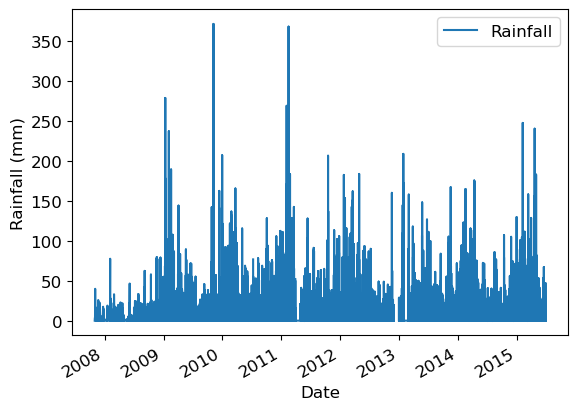

In [128]:
train_df.plot(x="Date", y="Rainfall")
plt.ylabel("Rainfall (mm)");

#### Lag-based features

In [129]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [130]:
train_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


- It looks like the dataframe is already sorted by Location and then by date for each Location.
- We could have done this ourselves if needed
> But make sure to also sort the targets (i.e. do this before preprocessing).

In [131]:
train_df = train_df.assign(Rainfall_lag1=train_df["Rainfall"].shift(1))

In [132]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][:20]

,Date,Location,Rainfall,Rainfall_lag1
0,2008-12-01,Albury,0.6,NaN
1,2008-12-02,Albury,0.0,0.6
2,2008-12-03,Albury,0.0,0.0
3,2008-12-04,Albury,0.0,0.0
4,2008-12-05,Albury,1.0,0.0
5,2008-12-06,Albury,0.2,1.0
6,2008-12-07,Albury,0.0,0.2
7,2008-12-08,Albury,0.0,0.0
8,2008-12-09,Albury,0.0,0.0
9,2008-12-10,Albury,1.4,0.0


- But we have multiple time series here and we need to be more careful with this. 
- When we switch from one location to another we do not want to take the value from the previous location. 

In [133]:
def create_lag_feature(df, orig_feature, lag):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int."""
    # note: pandas .shift() kind of does this for you already, but oh well I already wrote this code

    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    for location, df_location in new_df.groupby(
        "Location"
    ):  # Each location is its own time series
        new_df.loc[df_location.index[lag:], new_feature_name] = df_location.iloc[:-lag][
            orig_feature
        ].values
    return new_df

In [134]:
train_df = create_lag_feature(train_df, "Rainfall", 1)

In [135]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][2285:2295]

,Date,Location,Rainfall,Rainfall_lag1
2309,2015-06-26,Albury,0.2,1.0
2310,2015-06-27,Albury,0.0,0.2
2311,2015-06-28,Albury,0.2,0.0
2312,2015-06-29,Albury,0.0,0.2
2313,2015-06-30,Albury,0.0,0.0
3040,2009-01-01,BadgerysCreek,0.0,NaN
3041,2009-01-02,BadgerysCreek,0.0,0.0
3042,2009-01-03,BadgerysCreek,0.0,0.0
3043,2009-01-04,BadgerysCreek,0.0,0.0
3044,2009-01-05,BadgerysCreek,0.0,0.0


- Question: is it OK to do this to the test set? Discuss.
- It's fine if you would have this information available in deployment.
- If we're just forecasting the next day, we should.
- Let's include it for now.

In [136]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")
rain_df_modified

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_lag1
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,NaN
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.6
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [137]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Rainfall_lag1"],
    categorical_features,
    drop_features,
    target
)

In [138]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.84


In [139]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

,Coef
Rainfall,0.08110
Rainfall_lag1,0.00831


- Rainfall from today has a positive coefficient. 
- Rainfall from yesterday has a positive but a smaller coefficient. 
- If we didn't have rainfall from today feature, rainfall from yesterday feature would have received a bigger coefficient.

- We could also create a lagged version of the target.
- In fact, this dataset already has that built in! `RainToday` is the lagged version of the target `RainTomorrow`.
- We could also create lagged version of other features, or more lags

In [140]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 2)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 3)
rain_df_modified = create_lag_feature(rain_df_modified, "Humidity3pm", 1)

In [141]:
rain_df_modified[
    [
        "Date",
        "Location",
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
].head(10)

,Date,Location,Rainfall,Rainfall_lag1,Rainfall_lag2,Rainfall_lag3,Humidity3pm,Humidity3pm_lag1
0,2008-12-01,Albury,0.6,NaN,NaN,NaN,22.0,NaN
1,2008-12-02,Albury,0.0,0.6,NaN,NaN,25.0,22.0
2,2008-12-03,Albury,0.0,0.0,0.6,NaN,30.0,25.0
3,2008-12-04,Albury,0.0,0.0,0.0,0.6,16.0,30.0
4,2008-12-05,Albury,1.0,0.0,0.0,0.0,33.0,16.0
5,2008-12-06,Albury,0.2,1.0,0.0,0.0,23.0,33.0
6,2008-12-07,Albury,0.0,0.2,1.0,0.0,19.0,23.0
7,2008-12-08,Albury,0.0,0.0,0.2,1.0,19.0,19.0
8,2008-12-09,Albury,0.0,0.0,0.0,0.2,9.0,19.0
9,2008-12-10,Albury,1.4,0.0,0.0,0.0,27.0,9.0


In [142]:
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [143]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features
    + ["Rainfall_lag1", "Rainfall_lag2", "Rainfall_lag3", "Humidity3pm_lag1"],
    categorical_features,
    drop_features,
    target
)

In [144]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.85


In [145]:
lr_coef.loc[
    [
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
]

,Coef
Rainfall,0.108545
Rainfall_lag1,0.023093
Rainfall_lag2,0.018291
Rainfall_lag3,0.017822
Humidity3pm,1.278706
Humidity3pm_lag1,-0.267513


## Final remarks 

What did we not cover?

- A huge amount!

### Traditional time series approaches

- Time series analysis is a huge field of its own (notice a pattern here?)
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We took different route in this course, and stick to our supervised learning tools.

### Deep learning 

- Recently, deep learning has been very successful too.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - These are not covered in CPSC 340, but I believe they are in 440/540.
  - [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) especially have shown a lot of promise in this type of task.
  - [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a blog post about LSTMs.

### Types of problems involving time series

- A single label associated with an entire time series. 
  - We had that with images earlier on, you could have the same for a time series.
  - E.g., for fraud detection, labelling each transaction as fraud/normal vs. labelling a person as bad/good based on their entire history.
  - There are various approaches that can be used for this type of problem, including CNNs (Lecture 19), LSTMs, and non deep learning methods.
- Inference problems
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
  - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month.
  - Some of our approaches would not make sense, like the lags.
  - Perhaps the measurements could be binned into equally spaced bins, or something.
  - This is more of a hassle.

### Other software package

- A good one to know about is [Prophet](https://facebook.github.io/prophet/docs/quick_start.html).
- [sktime](https://www.sktime.net/en/stable/get_started.html)
    - Time series classification
    - forecasting
- [tslearn](https://tslearn.readthedocs.io/en/stable/)
    - classification
    - regression
    - clustering

### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.